# Synopsis

Collect all lexicons into a single database.

# Configuration

In [42]:
bing_pos_file = './opinion-lexicon-English/positive-words.txt'
bing_neg_file = './opinion-lexicon-English/negative-words.txt'
nrc_file = "./opinion-lexicon-English/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
syuzhet_file = "./opinion-lexicon-English/syuzhet.csv"
gi_file = "./opinion-lexicon-English/gi.csv"
my_pwd = 'C:/Users/karan/Documents/GitHub/text_analytics_final_project'

# Libraries

In [8]:
import sqlite3
import pandas as pd
import re

# Pragmas

In [9]:
%matplotlib inline
%cd {my_pwd}

C:\Users\karan\Documents\GitHub\text_analytics_final_project


# Process

## Import Bing lexicon

First, download RAR file from [here](http://sentiment.christopherpotts.net/lexicons.html#opinionlexicon).  Then open in a text editor and convert encoding and line endings in an editor.

In [14]:
bing_list = [(word.strip(), 'bing_positive', 1) 
             for word in open(bing_pos_file, 'r').readlines() 
             if re.match(r'^\w+$', word)]
bing_list += [(word.strip(), 'bing_negative', 1) 
              for word in open(bing_neg_file, 'r').readlines() 
              if re.match(r'^\w+$', word)]

In [28]:
bing = pd.DataFrame(bing_list, columns=['term_str', 'polarity', 'val'])
bing = bing.set_index(['term_str','polarity'],append=True)
bing = bing.unstack().fillna(0).astype('int')
bing.columns = bing.columns.droplevel(0)

In [29]:
bing.sum()

polarity
bing_negative    4660
bing_positive    1904
dtype: int64

In [48]:
bing.head()

,polarity,bing_negative,bing_positive,bing_sentiment
,term_str,,,
0,abound,0,1,1
1,abounds,0,1,1
2,abundance,0,1,1
3,abundant,0,1,1
4,accessable,0,1,1


In [50]:
bing=bing.reset_index(level=0)

In [51]:
bing.head()

polarity,level_0,bing_negative,bing_positive,bing_sentiment
term_str,,,,
abound,0,0,1,1
abounds,1,0,1,1
abundance,2,0,1,1
abundant,3,0,1,1
accessable,4,0,1,1


### Create single sentiment column

In [31]:
bing['bing_sentiment'] = bing['bing_positive'] - bing['bing_negative']

In [37]:
bing.sample(10)

,polarity,bing_negative,bing_positive,bing_sentiment
,term_str,,,
6542,wretchedly,1,0,-1
1575,soothe,0,1,1
3447,faithless,1,0,-1
5486,savages,1,0,-1
742,fruitful,0,1,1
1044,likes,0,1,1
2381,buzzing,1,0,-1
3112,disorient,1,0,-1
5337,remorseless,1,0,-1


## Import NRC lexicon

In [39]:
nrc = pd.read_csv(nrc_file, sep='\t', header=None)
nrc.columns = ['term_str','nrc_emotion','val']
nrc = nrc.set_index(['term_str','nrc_emotion'])
nrc = nrc.unstack()
nrc.columns = nrc.columns.droplevel(0)
nrc = nrc[nrc.sum(1) > 1]
nrc.columns = ['nrc_'+col for col in nrc.columns]

In [40]:
nrc.sum().sort_values(ascending=False)

nrc_negative        2366
nrc_fear            1368
nrc_positive        1281
nrc_anger           1208
nrc_sadness         1137
nrc_disgust         1004
nrc_trust            935
nrc_joy              686
nrc_anticipation     682
nrc_surprise         454
dtype: int64

In [41]:
nrc.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust
term_str,,,,,,,,,,
abandon,0,0,0,1,0,1,0,1,0,0
abandoned,1,0,0,1,0,1,0,1,0,0
abandonment,1,0,0,1,0,1,0,1,1,0
abduction,0,0,0,1,0,1,0,1,1,0
aberration,0,0,1,0,0,1,0,0,0,0


## Import Syuzhet lexicon

In [43]:
syu = pd.read_csv(syuzhet_file)
syu.columns = ['id','term_str','syu_sentiment']
syu = syu.drop('id', 1)
syu = syu.set_index('term_str')

In [44]:
syu.head()

,syu_sentiment
term_str,
abandon,-0.75
abandoned,-0.50
abandoner,-0.25
abandonment,-0.25
abandons,-1.00


## Import General Inquirer lexicon

This is prepared in a separate notebook.

In [45]:
gi = pd.read_csv(gi_file, index_col=['term_str'])
gi.columns = ['gi_sentiment']

In [46]:
gi.head()

,gi_sentiment
term_str,
abandon,-1
abandonment,-1
abate,-1
abdicate,-1
abhor,-1


## Combine all

In [54]:
combo = nrc.join(bing, how='outer')\
    .join(syu, how='outer')\
    .join(gi, how='outer')\
    .sort_index()

In [115]:
combo.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
term_str,,,,,,,,,,,,,,,
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-0.75,-1.0
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-0.50,NaN
abandoner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.25,NaN
abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,-0.25,-1.0
abandons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.00,NaN


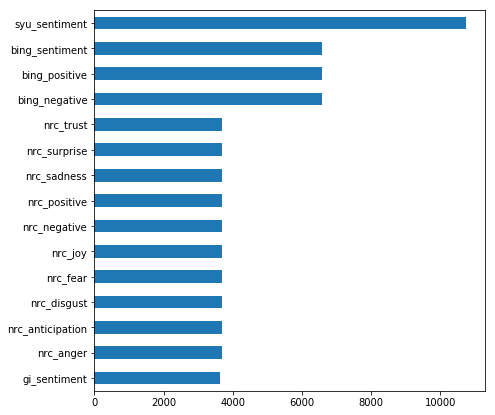

In [56]:
combo.count().sort_values().plot(kind='barh', figsize=(7,7))

# Save

In [57]:
with sqlite3.connect('lexicons.db') as db:
    nrc.to_sql('nrc', db, index=True, if_exists='replace')
    bing.to_sql('bing', db, index=True, if_exists='replace')
    syu.to_sql('syuzhet', db, index=True, if_exists='replace')
    gi.to_sql('gi', db, index=True, if_exists='replace')
    combo.to_sql('combo', db, index=True, if_exists='replace')        

# Get Ready for Sentiment Analysis

In [58]:
lex_db = './lexicons.db'
# emo = 'bing_sentiment'
emo = 'syu_sentiment'

# For KDE
kde_kernel = 'gaussian'
# kde_bandwidth = 100
kde_samples = 1000

import pandas as pd
import numpy as np
import scipy as sp
import sys
import scipy.fftpack as fftpack
from sklearn.neighbors import KernelDensity as KDE
from sklearn.preprocessing import scale

import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML

In [59]:
%matplotlib inline
sns.set()
plt.style.use('fivethirtyeight')

# Get Lexicons

In [60]:
with sqlite3.connect(lex_db) as db:
    combo = pd.read_sql('SELECT * FROM combo', db, index_col='term_str')

In [61]:
combo.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
term_str,,,,,,,,,,,,,,,
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-0.75,-1.0
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-0.50,NaN
abandoner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.25,NaN
abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,-0.25,-1.0
abandons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.00,NaN


In [62]:
# get lexicon columns
emo_cols = combo.columns
emo_cols

Index(['nrc_anger', 'nrc_anticipation', 'nrc_disgust', 'nrc_fear', 'nrc_joy',
       'nrc_negative', 'nrc_positive', 'nrc_sadness', 'nrc_surprise',
       'nrc_trust', 'bing_negative', 'bing_positive', 'bing_sentiment',
       'syu_sentiment', 'gi_sentiment'],
      dtype='object')

# Get Text

In [66]:
import pandas as pd
tokens=pd.read_csv('subset_tokens.csv')
vocab=pd.read_csv('vocab_subset.csv')

In [68]:
tokens=tokens.set_index(['artist_id', 'song_id','verse_num','line_num'])

In [71]:
vocab=vocab.set_index('term_id')

In [77]:
tokens=tokens.rename(columns={'token_str':'term_str'})

In [78]:
#Merge sentiment lexicon with vocab
tokens = tokens.join(combo, on='term_str', how='left')

In [79]:
tokens.head()

token_num term_str  punc  num  \
artist_id song_id verse_num line_num                                  
86        9992    0         0                 0    hands     0    0   
                            0                 4  stretch     0    0   
                            0                10      got     0    0   
                            1                 0     give     0    0   
                            1                 6     best     0    0   

                                      nrc_anger  nrc_anticipation  \
artist_id song_id verse_num line_num                                
86        9992    0         0               NaN               NaN   
                            0               NaN               NaN   
                            0               NaN               NaN   
                            1               NaN               NaN   
                            1               NaN               NaN   

                                      nrc_disgust  nrc_fear  nrc_joy  \
artist_id song_id verse_num line_num                                   
86        9992    0         0                 NaN       NaN      NaN   
                            0                 NaN       NaN      NaN   
                            0                 NaN       NaN      NaN   
                            1                 NaN       NaN      NaN   
                            1                 NaN       NaN      NaN   

                                      nrc_negative  nrc_positive  nrc_sadness  \
artist_id song_id verse_num line_num                                            
86        9992    0         0                  NaN           NaN          NaN   
                            0                  NaN           NaN          NaN   
                            0                  NaN           NaN          NaN   
                            1                  NaN           NaN          NaN   
                            1                  NaN           NaN          NaN   

                                      nrc_surprise  nrc_trust  bing_negative  \
artist_id song_id verse_num line_num                                           
86        9992    0         0                  NaN        NaN            NaN   
                            0                  NaN        NaN            NaN   
                            0                  NaN        NaN            NaN   
                            1                  NaN        NaN            NaN   
                            1                  NaN        NaN            0.0   

                                      bing_positive  bing_sentiment  \
artist_id song_id verse_num line_num                                  
86        9992    0         0                   NaN             NaN   
                            0                   NaN             NaN   
                            0                   NaN             NaN   
                            1                   NaN             NaN   
                            1                   1.0             1.0   

                                      syu_sentiment  gi_sentiment  
artist_id song_id verse_num line_num                               
86        9992    0         0                   NaN           NaN  
                            0                   NaN           NaN  
                            0                   NaN           NaN  
                            1                   NaN           1.0  
                            1                   0.5           1.0

In [ ]:
tokens[emo_cols] = tokens[emo_cols].fillna(0)

In [82]:
tokens[emo].sample(10)

artist_id  song_id  verse_num  line_num
424        43018    5          2           0.00
259        26366    11         0           0.00
496        49414    2          0           0.00
424        43025    4          2           0.50
           43119    1          0           0.00
264        26828    5          2           0.25
261        26487    6          6           0.50
           26527    1          4           0.25
580        55605    0          12         -0.50
500        49780    3          0           0.00
Name: syu_sentiment, dtype: float64

In [83]:
#sentiment by OHCO
OHCO = ['artist_id', 'song_id', 'verse_num', 'line_num','token_num']

In [85]:
FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)

In [101]:
tokens.head()

token_num term_str  punc  num  \
artist_id song_id verse_num line_num                                  
86        9992    0         0                 0    hands     0    0   
                            0                 4  stretch     0    0   
                            0                10      got     0    0   
                            1                 0     give     0    0   
                            1                 6     best     0    0   

                                      nrc_anger  nrc_anticipation  \
artist_id song_id verse_num line_num                                
86        9992    0         0               0.0               0.0   
                            0               0.0               0.0   
                            0               0.0               0.0   
                            1               0.0               0.0   
                            1               0.0               0.0   

                                      nrc_disgust  nrc_fear  nrc_joy  \
artist_id song_id verse_num line_num                                   
86        9992    0         0                 0.0       0.0      0.0   
                            0                 0.0       0.0      0.0   
                            0                 0.0       0.0      0.0   
                            1                 0.0       0.0      0.0   
                            1                 0.0       0.0      0.0   

                                      nrc_negative  nrc_positive  nrc_sadness  \
artist_id song_id verse_num line_num                                            
86        9992    0         0                  0.0           0.0          0.0   
                            0                  0.0           0.0          0.0   
                            0                  0.0           0.0          0.0   
                            1                  0.0           0.0          0.0   
                            1                  0.0           0.0          0.0   

                                      nrc_surprise  nrc_trust  bing_negative  \
artist_id song_id verse_num line_num                                           
86        9992    0         0                  0.0        0.0            0.0   
                            0                  0.0        0.0            0.0   
                            0                  0.0        0.0            0.0   
                            1                  0.0        0.0            0.0   
                            1                  0.0        0.0            0.0   

                                      bing_positive  bing_sentiment  \
artist_id song_id verse_num line_num                                  
86        9992    0         0                   0.0             0.0   
                            0                   0.0             0.0   
                            0                   0.0             0.0   
                            1                   0.0             0.0   
                            1                   1.0             1.0   

                                      syu_sentiment  gi_sentiment  
artist_id song_id verse_num line_num                               
86        9992    0         0                   0.0           0.0  
                            0                   0.0           0.0  
                            0                   0.0           0.0  
                            1                   0.0           1.0  
                            1                   0.5           1.0

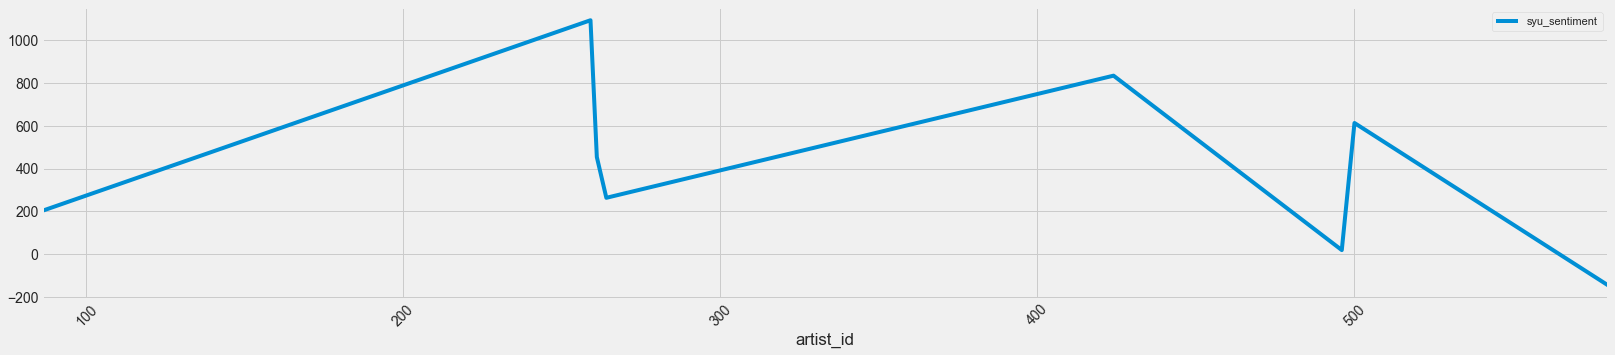

In [86]:
#By Artist, not that useful
tokens.groupby('artist_id')[emo].sum().plot(**FIG)

In [ ]:
# read in data that includes the names of the songs and artists
songs_df = pd.read_csv('songs_key_FULL.csv')
songs_df=songs_df.drop(columns=['Unnamed: 0', 'text'])
artists_df=pd.read_csv('artists_key.csv')
artists_df.columns=['artist_id','artist']
artist_song_df=pd.merge(songs_df,artists_df)
#artist_song_df = artist_song_df.drop(columns=['Unnamed: 0', 'text'])
#artist_song_df.head()

In [160]:
artist_sentiment=tokens.reset_index('artist_id')
artist_sentiment=pd.DataFrame(tokens.groupby('artist_id')[emo].sum())
artist_sentiment=artist_sentiment.reset_index('artist_id')
artist_sentiment=pd.merge(artist_sentiment,artists_df)

In [161]:
#Surprisingly, David Guetta is the least positive artist, while Justin Beiber is the most positive artist.
artist_sentiment.head()

,artist_id,syu_sentiment,artist
0,86,202.25,David Guetta
1,259,1093.60,Justin Bieber
2,261,454.00,Kanye West
3,264,263.45,Katy Perry
4,424,834.50,Queen


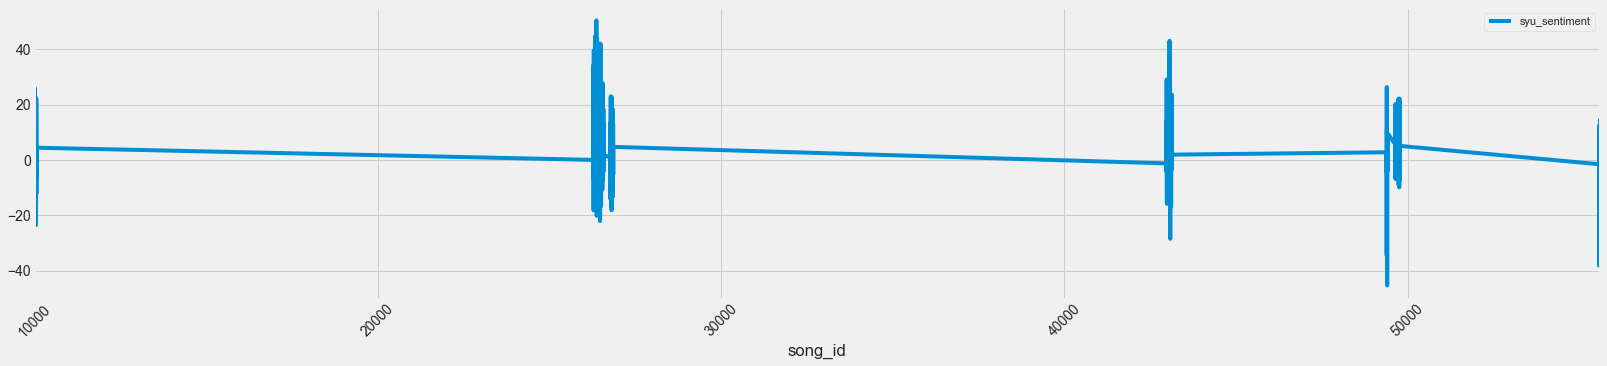

In [87]:
# By Song, not a useful graph
tokens.groupby('song_id')[emo].sum().plot(**FIG)

In [172]:
#Breaking down to a song level- let's check the sentiment scores for Kanye songs
kanye=tokens.reset_index('artist_id')
kanye=kanye[kanye.artist_id==261]
kanye=kanye.drop(columns='artist_id')

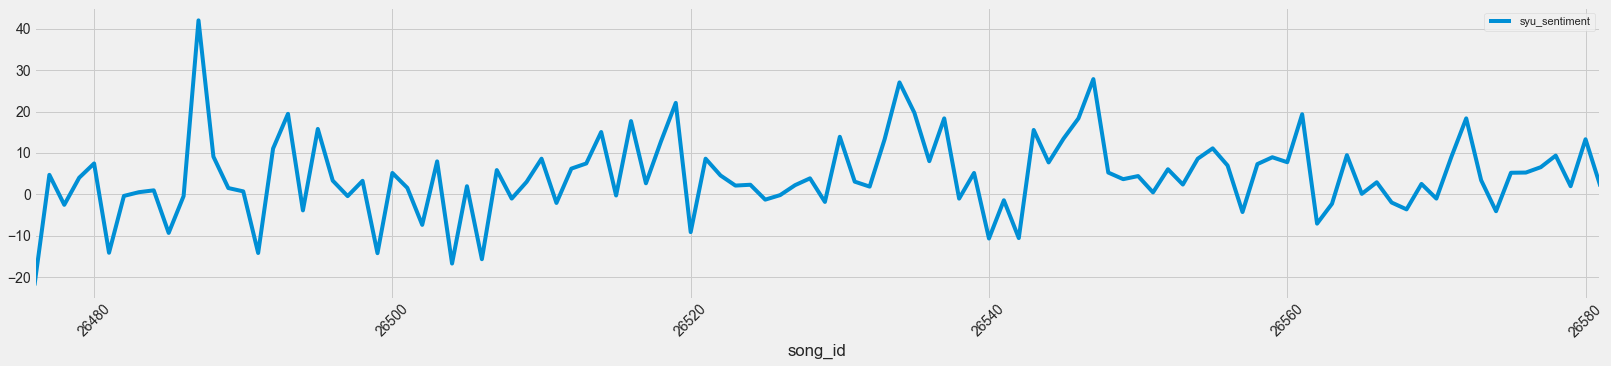

In [173]:
kanye.groupby('song_id')[emo].sum().plot(**FIG)

In [174]:
kanye_song_sentiment=pd.DataFrame(kanye.groupby('song_id')[emo].sum())

In [175]:
kanye_song_sentiment.head()

,syu_sentiment
song_id,
26476,-22.05
26477,4.70
26478,-2.55
26479,4.00
26480,7.45


In [176]:
kanye_song_sentiment=kanye_song_sentiment.reset_index()

In [177]:
kanye_song_sentiment=pd.merge(kanye_song_sentiment,songs_df)

In [178]:
kanye_song_sentiment.sort_values(by=['syu_sentiment'],ascending=False)

,song_id,syu_sentiment,artist,song,artist_id
11,26487,42.05,Kanye West,Diamonds,261
71,26547,27.85,Kanye West,I Just Wanna Love U (Offcial Kanye West Mumtri...,261
58,26534,27.05,Kanye West,Good Friday,261
43,26519,22.10,Kanye West,Classic,261
59,26535,19.70,Kanye West,Good Life,261
17,26493,19.45,Kanye West,Family Business,261
85,26561,19.35,Kanye West,Pinocchio Story,261
96,26572,18.35,Kanye West,See Me Now,261
70,26546,18.35,Kanye West,I Got A Love,261
61,26537,18.35,Kanye West,Good Night,261


In [162]:
#Let's check on our most positive artist, Justin Bieber

weeknd=tokens.reset_index('artist_id')
weeknd=weeknd[weeknd.artist_id==259]
weeknd=weeknd.drop(columns='artist_id')
weeknd_swift_sentiment=pd.DataFrame(weeknd.groupby('song_id')[emo].sum())


In [163]:
weeknd_swift_sentiment=weeknd_swift_sentiment.reset_index()
weeknd_swift_sentiment=pd.merge(weeknd_swift_sentiment,songs_df)
weeknd_swift_sentiment.sort_values(by=['syu_sentiment'],ascending=False)

#As I suspected, his score is inflated by his christmas album

,song_id,syu_sentiment,artist,song,artist_id
82,26367,50.45,Justin Bieber,Love Me Like You Do,259
47,26332,44.80,Justin Bieber,Baby,259
103,26388,43.90,Justin Bieber,Right Here,259
8,26293,39.65,Justin Bieber,Christmas Love,259
3,26288,34.45,Justin Bieber,As Long As You Love Me,259
64,26349,33.10,Justin Bieber,Favorite Girl,259
84,26369,32.45,Justin Bieber,Madly In Love (Bigger Than Life),259
39,26324,30.55,Justin Bieber,U Smile,259
14,26299,30.15,Justin Bieber,Forever,259
68,26353,29.70,Justin Bieber,Happy New Year,259


## Let's breakup a Justin Beiber song and explore its sentiment by verse

In [164]:
weeknd.head()

token_num   term_str  punc  num  nrc_anger  \
song_id verse_num line_num                                               
26285   0         0                 6        day     0    0        0.0   
                  0                10  christmas     0    0        0.0   
                  1                 0     justin     0    0        0.0   
                  1                 2     bieber     0    0        0.0   
                  1                 4       gave     0    0        0.0   

                            nrc_anticipation  nrc_disgust  nrc_fear  nrc_joy  \
song_id verse_num line_num                                                     
26285   0         0                      0.0          0.0       0.0      0.0   
                  0                      0.0          0.0       0.0      0.0   
                  1                      0.0          0.0       0.0      0.0   
                  1                      0.0          0.0       0.0      0.0   
                  1                      0.0          0.0       0.0      0.0   

                            nrc_negative  nrc_positive  nrc_sadness  \
song_id verse_num line_num                                            
26285   0         0                  0.0           0.0          0.0   
                  0                  0.0           0.0          0.0   
                  1                  0.0           0.0          0.0   
                  1                  0.0           0.0          0.0   
                  1                  0.0           0.0          0.0   

                            nrc_surprise  nrc_trust  bing_negative  \
song_id verse_num line_num                                           
26285   0         0                  0.0        0.0            0.0   
                  0                  0.0        0.0            0.0   
                  1                  0.0        0.0            0.0   
                  1                  0.0        0.0            0.0   
                  1                  0.0        0.0            0.0   

                            bing_positive  bing_sentiment  syu_sentiment  \
song_id verse_num line_num                                                 
26285   0         0                   0.0             0.0            0.0   
                  0                   0.0             0.0            0.0   
                  1                   0.0             0.0            0.0   
                  1                   0.0             0.0            0.0   
                  1                   0.0             0.0            0.0   

                            gi_sentiment  
song_id verse_num line_num                
26285   0         0                  0.0  
                  0                  0.0  
                  1                  0.0  
                  1                  0.0  
                  1                  0.0

In [ ]:
by_verse = tokens.groupby(SENTS)[emo_cols].sum()